# Embedding the mind of a worm 

## Motivation

C. Elegans is a transparent roundworm of about 1mm length. It is one of the most famous model organisms and has been studied extensively since the 1960s. Research is still very much ongoing with the C. Elegans conference taking place every two years (2023 in Glasgow). C. Elegans has a complex behavioural repetoire which includes touch sensitivity, egg laying, feeding, exploration and escape behaviour, all whith only 302 neurons (Chatterjee & Sinha, 2007). Not only has it's whole genome been sequenced, C. Elegans was the first animal to have the connectome of its nervous system fully described (White et. al 1987). 

The dataset used for this project (https://braingraph.org/cms/c-elegans/) is a digitised version of the origianal description of the connectome by White et. al (1987). The aim is to explore the relationship between the function of a neuron and its place within the network. This will be done by embedding each neuron in a 20-dimensional space that preserves the graph structure. Classifiers will be trained to predict a neuron's function (sensory, motor or interneuron) and its links to other neurons, using only their position in the embedding space. 
These classifiers will then be used to investigate a subset of synapses whose descriptions in the original dataset were deemed questionable after review due to misprints. An expert might be helped by a tool like this to make a descion about what description of the synapse is most likely correct. Since there are only about 8000 chemical synapses it is important that everything is described correcly. 


In [2]:
#imports
import pandas as pd 
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from node2vec import Node2Vec #https://pypi.org/project/node2vec/

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepraring the data

In [4]:
#loading the synapse data
data = pd.read_csv('White_Fig/synapse_WF.txt', sep="\s+", header=None)
data.columns = ["Reference neuron", "Index of process", "Serial number of synaptic contact", "Serial number of synapse symbol", "Index of synapse type", "Partner neuron", "Multiplicity index", "Comment index"]
#naming the columns

There are some synapses that include non-neurons (described in README_WF.txt) that need to be filtered out.

In [315]:
#filtering out the synapses that include non_neurons
non_neurons = ['HDC', 'MUSCLE', "NMJ", "vm2"] #These entries are not neurons and should be filtered out.
start_strings = ['CEPsh', 'GLR'] # Entries that start with these letters should also be filtered out (I checked that there are no neurons that start with these letters) 
data = data[~(data['Reference neuron'].isin(non_neurons) | data['Reference neuron'].str.startswith(tuple(start_strings)))] # Filter out these entries from the 'Reference neuron' column
data = data[~(data['Partner neuron'].isin(non_neurons) | data['Partner neuron'].str.startswith(tuple(start_strings)))] # And then filter out these entries from the 'Partner neuron' column
data.head(1)

,Reference neuron,Index of process,Serial number of synaptic contact,Serial number of synapse symbol,Index of synapse type,Partner neuron,Multiplicity index,Comment index
0,ADAL,A,1,1,G,ADAL,-,wf5


In [7]:
#loading the data that describes the class and function of each neuron
neurons = pd.read_csv('name_neurons.txt', sep="\s+", header=None)
neurons.columns = ["Neuron name", "Neuron class", "Neuron function"]
filtered_neurons = neurons[neurons['Neuron function'].isin(['se', 'mo'])] # In order to not make the node classification tasks too difficult, first only try with sensory neurons and motor neurons
filtered_neurons2 = neurons[neurons['Neuron function'].isin(['se', 'mo', 'in'])] #Then add interneurons 

The coloumns we are most interested in are 'Reference neuron', 'Index of synapse type', and 'Partner neuron'. Index of synapse type has the following possible entries (descriptions taken from READNE_WF.txt)

  "S": The reference neuron sends chemical synapse to its partner neuron.

  "R": The reference neuron receives chemical synapse from its partner neuron.

  "G": A gap junction connects the reference neuron with its partner neuron.
  
  "-": A symbol of synapse type is missing.

We will not look a gap junctions because they are undirected and we want to create a directed graph. 

In theory 'a record of Neuron A sending a chemical synapse to Neuron B must be paired with a record of Neuron B receiving a chemical synapse from Neuron A.' (Varshney et al., 2011). This assumption unfortunatly does not hold because in this dataset when a multiple synapse is sent, all possible receivers are recorded with an 'S' but only the receivers that were actually observed to receive the signal are recorded with an 'R'. This means that there are more 'S' synapses than 'R' synapses. We will be working with the 'S' synapses.

We will also filter out all synapses that have comments attached to them as we don't want to train the classifier on synapses that might not be described correctly. 

In [319]:
#get rid of any edges that have comments and all the gap junctions as we want to make a directed graph.
graph_data = data[(data['Index of synapse type'] == 'S') & (data["Comment index"] == "-")][["Reference neuron", "Index of synapse type", "Partner neuron"]] 
graph_data_filtered = graph_data[graph_data['Reference neuron'].isin(filtered_neurons['Neuron name']) & graph_data['Partner neuron'].isin(filtered_neurons['Neuron name'])] #sensory and motor neurons
graph_data_filtered2 = graph_data[graph_data['Reference neuron'].isin(filtered_neurons2['Neuron name']) & graph_data['Partner neuron'].isin(filtered_neurons2['Neuron name'])] #sensory, motor and interneurons
graph_data_filtered3 = graph_data[graph_data['Reference neuron'].isin(neurons['Neuron name']) & graph_data['Partner neuron'].isin(neurons['Neuron name'])] #all the neurons

We now have three dataframes. The first only includes sensory and motor neurons, the second includes sensory, motor, and interneurons and the third includes all neurons (including neurons that have multiple functions). The first two will be used for the node classification taks, the third will be used for the link prediction task.

## Node Classification

First create a directed graph of only motor and sensory neurons

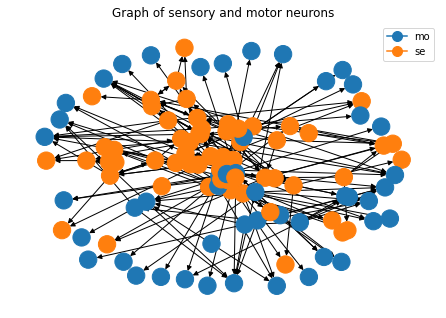

In [418]:
G = nx.DiGraph()
edges_s = [(row['Reference neuron'], row['Partner neuron'], {'index': idx}) for idx, row in graph_data_filtered.iterrows()] 
G.add_edges_from(edges_s) #for each row add an edge from reference neuron to partner neuron

neuron_info_dict = neurons.set_index('Neuron name')[['Neuron class', 'Neuron function']].T.to_dict('list') #this is to keep track of the neuron functions 
for node in G.nodes: #add the function of each neuron as an attribute
    G.nodes[node]['Neuron'] = node
    if node in neuron_info_dict:
        G.nodes[node]['Neuron class'] = neuron_info_dict[node][0]
        G.nodes[node]['Neuron function'] = neuron_info_dict[node][1]

palette = sns.color_palette("tab10", 3) #get the Seaborn color palette so that the graphs all look similar 
color_map1 = []
for node in G.nodes:
    if G.nodes[node]['Neuron function'] == 'mo':
        color_map1.append(palette[0])  
    elif G.nodes[node]['Neuron function'] == 'se':
        color_map1.append(palette[1])  

nx.draw(G, node_color=color_map1)

mo_patch = plt.Line2D([], [], color=palette[0], marker='o', markersize=10, label='mo') #create a legend, this was the most frustrating part of this project
se_patch = plt.Line2D([], [], color=palette[1], marker='o', markersize=10, label='se')
plt.legend(handles=[mo_patch, se_patch])
plt.title("Graph of sensory and motor neurons")
plt.show()


Create node embedding using node2vec. The hyperparameters are chosen to approximate Breadth-First-Search which should prioritise structural equivalence over homophily in the embedding space, which is what we want for this node classification task

Computing transition probabilities: 100%|██████████| 107/107 [00:00<00:00, 7716.08it/s]


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 723.64it/s]


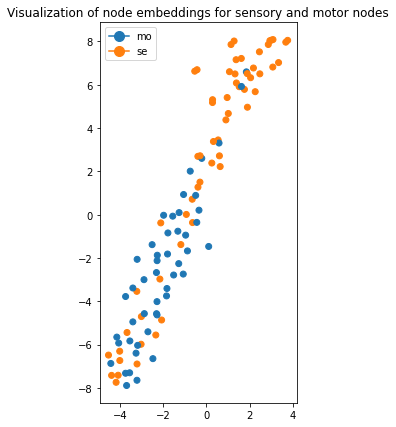

In [479]:
node2vec = Node2Vec(G, dimensions=20, walk_length=10, num_walks=10, workers=1, p=0.1, q=10)
model = node2vec.fit(window=10, min_count=1)
node2vec = model.wv.vectors

transform = TSNE  
trans = transform(n_components=2) #transform from 20 dimensions to 2 dim
node_embeddings_2d = trans.fit_transform(node2vec) #transform from 20 dimensions to 2 dim to visualise it

#draw the scatterplot
plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
scatter = plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=color_map1)
mo_patch = plt.Line2D([], [], color=palette[0], marker='o', markersize=10, label='mo')
se_patch = plt.Line2D([], [], color=palette[1], marker='o', markersize=10, label='se')
plt.legend(handles=[mo_patch, se_patch])
plt.title("Visualization of node embeddings for sensory and motor nodes")
plt.show()


Create a second directed graph of motor, sensory and interneurons

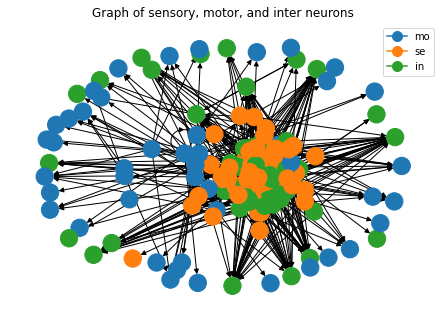

In [420]:
J = nx.DiGraph() #this is all the same as before except using the second dataframe. For some reason it takes a lot longer
edges_s = [(row['Reference neuron'], row['Partner neuron'], {'index': idx}) for idx, row in graph_data_filtered2.iterrows()]
J.add_edges_from(edges_s) 

neuron_info_dict = neurons.set_index('Neuron name')[['Neuron class', 'Neuron function']].T.to_dict('list')
for node in J.nodes:
    J.nodes[node]['Neuron'] = node
    if node in neuron_info_dict:
        J.nodes[node]['Neuron class'] = neuron_info_dict[node][0]
        J.nodes[node]['Neuron function'] = neuron_info_dict[node][1]

color_map2 = []
for node in J.nodes:
    if J.nodes[node]['Neuron function'] == 'mo':
        color_map2.append(palette[0])  
    elif J.nodes[node]['Neuron function'] == 'se':
        color_map2.append(palette[1])  
    elif J.nodes[node]['Neuron function'] == 'in':
        color_map2.append(palette[2]) 

nx.draw(J, node_color=color_map2, with_labels=False)

mo_patch = plt.Line2D([], [], color=palette[0], marker='o', markersize=10, label='mo')
se_patch = plt.Line2D([], [], color=palette[1], marker='o', markersize=10, label='se')
in_patch = plt.Line2D([], [], color=palette[2], marker='o', markersize=10, label='in')
plt.legend(handles=[mo_patch, se_patch, in_patch])
plt.title("Graph of sensory, motor, and inter neurons")
plt.show()


Create node embeddings using node2vec. Note that the hyperparameters are not optimised, they are just chosen based on what the tsne visualisation looks like. 

Computing transition probabilities:   0%|          | 0/188 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 155.02it/s]


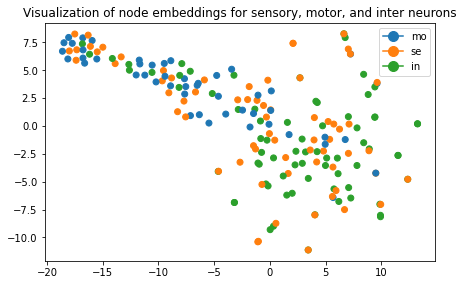

In [421]:
#same as before except with graph J 
twonode2vec = Node2Vec(J, dimensions=20, walk_length=20, num_walks=5, workers=1, p=0.1, q=10)
modelJ = twonode2vec.fit(window=10, min_count=1)
twonode2vec = modelJ.wv.vectors

transform = TSNE  
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(twonode2vec)

#draw the scatterplot
plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
scatter = plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=color_map2)
mo_patch = plt.Line2D([], [], color=palette[0], marker='o', markersize=10, label='mo')
se_patch = plt.Line2D([], [], color=palette[1], marker='o', markersize=10, label='se')
in_patch = plt.Line2D([], [], color=palette[2], marker='o', markersize=10, label='in')
plt.legend(handles=[mo_patch, se_patch, in_patch])
plt.title("Visualization of node embeddings for sensory, motor, and inter neurons")
plt.show()

Equiped with node embeddings for both graphs we can now train a scikit-learn classifier where the embedding matrix is the feature matrix

In [480]:
F1 = pd.DataFrame(columns=['two classes', 'three classes'])

neuron_function = nx.get_node_attributes(G,'Neuron function')
y = np.array(list(neuron_function.values())) #target array for the first graph
neuron_function = nx.get_node_attributes(J,'Neuron function')
y2 = np.array(list(neuron_function.values())) #target array for the second graph

for i in range(50): #do this for mutliple random states to get a better idea of the performance 

    X_train, X_test, y_train, y_test = train_test_split(node2vec, y, test_size = 0.20, random_state = i) #split data 
    logisticRegr = LogisticRegression() #initiate model
    logisticRegr.fit(X_train, y_train) #fit model to data 
    y_pred = logisticRegr.predict(X_test) #predict on new data
    F1.at[f'{i}','two classes'] = classification_report(y_test,y_pred,output_dict=True).get('weighted avg').get('f1-score') #print classification report and add the weighted F1 score to a dataframe

    X_train, X_test, y_train, y_test = train_test_split(twonode2vec, y2, test_size = 0.20, random_state = i) #same as above but for the node embedding of the second graph
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train, y_train)
    y_pred = logisticRegr.predict(X_test)
    F1.at[f'{i}','three classes'] = classification_report(y_test,y_pred,output_dict=True).get('weighted avg').get('f1-score') 


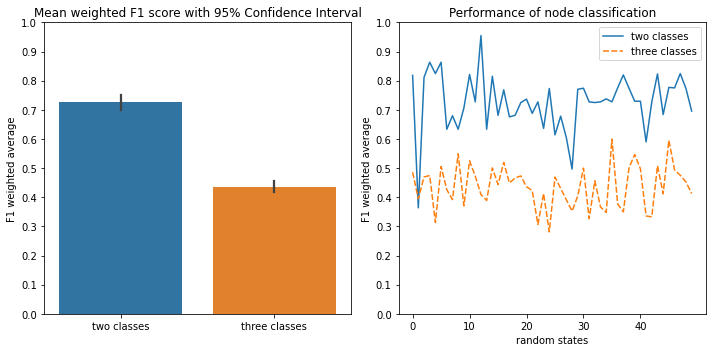

In [483]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotting the first graph
sns.barplot(data=F1, ax=axes[0])
axes[0].set_ylim([0, 1])
axes[0].set_yticks(np.arange(0, 1.1, 0.1))
axes[0].set_ylabel('F1 weighted average')
axes[0].set_title('Mean weighted F1 score with 95% Confidence Interval')

# Plotting the second graph
sns.lineplot(data=F1[['two classes', 'three classes']], ax=axes[1]).set_xticks(np.arange(0, 50, 10))
axes[1].set_ylim([0, 1])
axes[1].set_yticks(np.arange(0, 1.1, 0.1))
axes[1].set_xlabel('random states')
axes[1].set_ylabel('F1 weighted average')

plt.tight_layout()
plt.title("Performance of node classification")
plt.show()

For two classes the classifier seems to do ok with an average weighted F1 score of 72.6%

For three classes the average weighted F1 is score is 43.6%, only 10 percentage points over chance. It's safe to assume that if we added neurons that have multiple functions, the classifier would perform even more poorly. 

It looks like the relationship between function of neurons and network structure is far from straightforward. If we only look at sensory and motor neurons however there does seem to be a difference between their role in the network structure. This might be explained by the assertion that motor neurons have higher outdegree than indegree, sensory neurons have higher indegree than outdegree and interneurons have high indegree and high outdegree (Jingying, 2018). This would make distinguishing motor and sensory neurons a lot easier than if there are also interneurons who share properties with both, which is what we see here.

## Link prediction

In this part we will train a binary classifier to predict whether a link between two nodes exists or does not exist. 

First we make a new graph that includes all the neurons because we don't care anymore about the function.

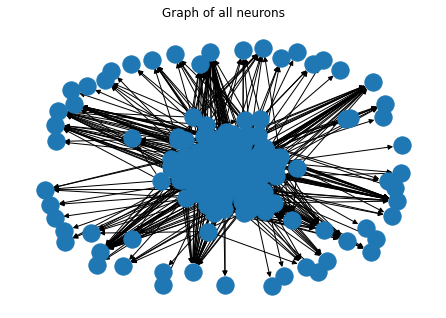

In [338]:
H = nx.DiGraph()
edges_s = [(row['Reference neuron'], row['Partner neuron'], {'index': idx}) for idx, row in graph_data_filtered3.iterrows()]
H.add_edges_from(edges_s) #again for each row add an edge from reference neuron to partner neuron

nx.draw(H)
plt.title("Graph of all neurons")
plt.show()

Create new node2vec embeddings, this time choosing hyperparameters that approximate Depth-First-Search which should prioritise homophily in the embedding space, which is what we want for this link prediction task

In [ ]:
#create node embedding for new graph
node_embeddings = Node2Vec(H, dimensions=20, walk_length=100, num_walks=5, workers=1, p=0.15, q=10) 
modelH = node_embeddings.fit(window=10, min_count=1)
node_embeddings = modelH.wv.vectors

Here is the visualisation of the edge embedding. An edge embedding is just the dot product of the embddings of the reference neuron and the partner neuron. Positive embeddings are the embeddings of edges that exist in our graph, while Negative embeddings represent edges that do not exist.

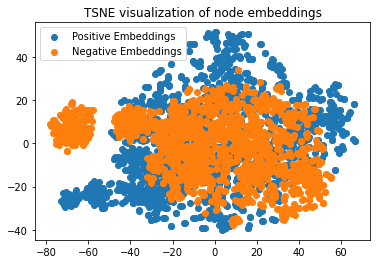

In [352]:
#create edge embedding
edges_positive = [(edge[0], edge[1]) for edge in H.edges()]  #positive class examples

edges_negative = [] #generate non-existent edges in the graph)
while len(edges_negative) < len(edges_positive): #we want the same number of positive and negative examples
    nodes = np.random.choice(H.nodes(), 2, replace=False)
    if not H.has_edge(nodes[0], nodes[1]): #if the randomly created edge does not exist add it to the negative examples
        edges_negative.append((nodes[0], nodes[1]))

node_mapping = {node: i for i, node in enumerate(H.nodes())} #create a mapping from nodes to integers 

#now use this mapping when accessing the embeddings
features_positive = [node_embeddings[node_mapping[i]] * node_embeddings[node_mapping[j]] for i, j in edges_positive] #the embedding for each link is the dotproduct of the individual embeddings of two neurons
features_negative = [node_embeddings[node_mapping[i]] * node_embeddings[node_mapping[j]] for i, j in edges_negative]

transform = TSNE  
trans = transform(n_components=2)
edge_embeddings_2d_positive = trans.fit_transform(np.array(features_positive)) #transform them seperatly so we keep track of where everything is
edge_embeddings_2d_negative = trans.fit_transform(np.array(features_negative))

#two scatterplots on top of each other with different colours
plt.scatter(edge_embeddings_2d_positive[:, 0], edge_embeddings_2d_positive[:, 1], color=palette[0], label='Positive Embeddings') 
plt.scatter(edge_embeddings_2d_negative[:, 0], edge_embeddings_2d_negative[:, 1], color=palette[1], label='Negative Embeddings')
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.legend()  
plt.show()

Now we can train a classifier on positive embeddings and negative embedding to predict whether an edge exists or not

In [353]:
labels_positive = [1 for _ in range(len(edges_positive))] #labels for positive examples
labels_negative = [0 for _ in range(len(edges_negative))] #labels negative examples

#combine feature sets and labels
features = features_positive + features_negative #feature matrix
labels = labels_positive + labels_negative #target vector

F1_link_prediction = pd.DataFrame(columns=['F1 weighted average']) 
for i in range(50): #again training it for multiple splits 
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=i)
    clf = LogisticRegression(random_state=0).fit(features_train, labels_train) #train a logistic regression classifier
    labels_pred = clf.predict(features_test) #üredict the labels for the test set
    F1_link_prediction.at[f'{i}','F1 weighted average'] = classification_report(labels_test, labels_pred, output_dict=True).get('weighted avg').get('f1-score')
    #print classification report and add the weighted F1 score to a dataframe so that we can plot it across differnt splits of the data

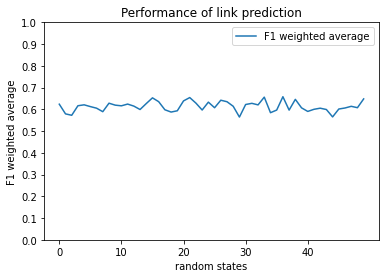

In [354]:
q = sns.lineplot(data=F1_link_prediction) 
q.set_xticks(np.arange(0, 50, 10))
q.set_yticks(np.arange(0, 1.1, 0.1))
q.set_xlabel('random states')
q.set_ylabel('F1 weighted average')

plt.title("Performance of link prediction")
plt.show()

The averege weighted F1 average is 61%, which is not very good. As it stands this classifier is probably useless when it comes to investigating the synapses that were deemed questionable because it performs only slightly above chance.

## Investigating misprints

Even though the classifier is not good I will demonstrate what I originally had in mind. None of the following analyisis should be taken at face-value, it only serves as a blueprint for what could be possible with a better representation of the graph. A better representation might be achieved by optimizing the hyperparameters of node2vec, more careful model selection, or using a Graph Neural Network.

In [408]:
def predict_links(node): #this function returns a dataframe with the probability with which the trained classifier would predict a link between the input node and every other node
    edge_features = []
    for i in H.nodes():
        edge_features.append(node_embeddings[node_mapping[node]] * node_embeddings[node_mapping[i]]) #create feature vectors for all possible links involving the given node

    edge_probs = clf.predict_proba(edge_features)[:, 1] #use the trained model to predict the probabilities of these links

    edge_links = {}
    nodes_list = list(H.nodes()) #so that we can access nodes in for loop
    for i in range(len(nodes_list)): 
        edge_links[nodes_list[i]] = edge_probs[i] #create a mapping from nodes to probabilities

    #put the predicted probabilities of links in a dataframe 
    return pd.DataFrame({'probability of link': edge_links}).sort_values(by='probability of link', ascending = False).reset_index().rename(columns={"index": "partner neurons"})

In [395]:
pd.set_option('display.max_columns', None) #otherwise it doesn't show all the coloumns for some reason
def prob_of_true_links(node, str): #this function returns a dataframe of all it's actual links and each link the probability with which the classifier the model would have predicted it to be a true link
    df1 = predict_links(node).sort_values(by='probability of link', ascending=False)
    if str == 'in': #so that you can specify if you want the in edges or out edges
        df2 = pd.DataFrame(H.in_edges(node))
        df2.columns = ['partner neurons', 'link']
    if str == 'out':
        df2 = pd.DataFrame(H.out_edges(node))
        df2.columns = ['link', 'partner neurons']
    merged_df = pd.merge(df1, df2, on='partner neurons') #inner join 
    merged_df = merged_df.drop('link', axis=1)
    return merged_df #I don't end up using this function but it's still fun to play around with

The comments I want to investigate are 

"wf21": The name of partner neuron is not clearly printed in the original figure

"wf24": Comment peculiar to RMDR. The name of partner neuron "SVPL" does                            
          not exist. It should be read "PVPL" or other names of neurons.
          
"wf25": Comment peculiar to RMGL. The name of partner neuron "RMVDL" does                           
          not exist. It should be read "RMDVL" or other names of neurons.


In [369]:
#this function is from https://medium.com/geekculture/jupyter-how-to-display-dataframes-horizontally-d8e8769f4fa6
from IPython.display import HTML

def horizontal(dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 32px">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

The following dataframes show predicted links for a neurons where a partner neuron was not clearly printed in the original figures. 

The top string in the index denotes the neuron we are predicting edges for. The bottom string in the index denotes what the authors of the digitised database thought the misprint most likely was. Below are the probabilities for links to partner neurons that start with the same two letters as the author's guess.

For the last two dataframes the 'authors's best guess' for a partner neuron does not exist.

In [409]:
DA3 = predict_links('DA3') #these are all the neurons that have a synapse with wf21, wf24 or wf25 as a comment index
PHAR = predict_links('PHAR')
RIBR = predict_links('RIBR')
RICL = predict_links('RICL')
RIGL = predict_links('RIGL')
RMDDR = predict_links('RMDDR')
RMED = predict_links('RMED')
RMDR = predict_links('RMDR')
RMGL = predict_links('RMGL')

comment_neurons = [[DA3, 'DA3', 'AS', 'AS11'], [PHAR, 'PHAR', 'PH', 'PHAL'], [RIBR, 'RIBR', 'RI', 'RIH'], [RICL, 'RICL', 'AS', 'ASHL'], [RIGL, 'RIGL', 'AV', 'AVHR'],
                   [RMDDR, 'RMDDR', 'IL', 'IL1R'], [RMED, 'RMED','IL','IL2DR'], [RMDR, 'RMDR', 'S', 'SVPL'], [RMGL, 'RMGL','RM', 'RMVDL']]
plot_comment_neurons = []
for neuron in comment_neurons: #find the probabilities of having an edge from the reference neuron to neurons that start with the same two letters as the author's best guess
    plot_comment_neurons.append(neuron[0][neuron[0]['partner neurons'].str.startswith(neuron[2])].rename(columns={"partner neurons": (f"{neuron[1]}, {neuron[3]}")}).style.hide()) #style.hide to hide the index
horizontal(plot_comment_neurons)

"DA3, AS11",probability of link
ASEL,0.528465
ASHL,0.524373
ASHR,0.500224
ASKR,0.464410
ASKL,0.456312
ASIR,0.449212
ASIL,0.448620
ASGL,0.437102
ASER,0.436642
ASGR,0.428285


For most of the misprints the author's best guess for what the partner neuron was supposed to be is given a probabability of less than 0.5 by the classifier. 
This is not too surprising because the classifier is not very good. 

## Conclusion

Regarding the opening question of whether it is possible to predict neuron classes and links from just the network structure, it is not straightforward. This indicates that the function of a neuron is neither defined nor fully reflected by it's place within the network structure. Knowing the architecture of a network is not enough to model it's function, we still have to look at the biological level to figure out the function of each neuron. However the classifiers do still perform above chance and maybe optimizing hyperparamers or representing the graph in a different way would give different results. Developments in graph convolutional networks will probably play a big part in computational neuroscience in the future. 